# Entropy and Information Analysis for Language Models

This notebook demonstrates how to compute **entropy** and **Shannon information** (surprisal) for each token in a sequence using the full probability distribution from a language model.

## Theory Overview

### Shannon Entropy
Measures **uncertainty** in the probability distribution before observing a token:

$$H(P) = -\sum_{i=1}^{V} P(x_i) \log_2 P(x_i)$$

where $V$ is the vocabulary size.

### Shannon Information (Surprisal)
Measures how **surprising** a specific observed token is:

$$I(x) = -\log_2 P(x)$$

### Key Insights
- **High entropy** → Model is uncertain (many likely tokens)
- **Low entropy** → Model is confident (few likely tokens)
- **High information** → Token was surprising/rare
- **Low information** → Token was expected/predictable

### Total Entropy of Sequence
Using the chain rule:

$$H(T_1, T_2, ..., T_n) = \sum_{i=1}^{n} H(T_i | T_{1:i-1})$$

This is exactly what we compute by summing entropy at each position!

## 1. Setup and Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Set up path to import local modules
sys.path.append(os.path.dirname(os.getcwd()))

from src.information_theory import compute_entropy, compute_shannon_information

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✓ Imports successful
PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3090


## 2. Load the Analyzer

We'll use the `FullDistributionEntropyAnalyzer` which:
1. Loads a language model via transformers
2. Extracts the **full probability distribution** over all tokens
3. Computes exact entropy and information values

In [2]:
# Import the analyzer
sys.path.append('../examples')
from entropy_full_distribution import FullDistributionEntropyAnalyzer

print("✓ Analyzer loaded")

✓ Analyzer loaded


In [3]:
# Initialize the analyzer
# Options:
# - "gpt2" - Small, open access (demo)
# - "meta-llama/Llama-3.1-8B" - Your local model (requires auth or local weights)
# - Path to local model weights

MODEL_NAME = "gpt2"  # Change this to your model

print(f"Loading model: {MODEL_NAME}...")
print("This may take a moment...\n")

analyzer = FullDistributionEntropyAnalyzer(
    model_path=MODEL_NAME,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print("\n✓ Model loaded and ready!")

Loading model: gpt2...
This may take a moment...

Loading model: gpt2
Device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Model loaded
Vocabulary size: 50,257 tokens


✓ Model loaded and ready!


## 3. Analyze a Sample String

Let's analyze: **"hello what is the entropy and information of this string"**

For each word, we'll:
1. Get the full probability distribution over ~50k tokens
2. Compute entropy from this distribution
3. Find the probability of the actual word
4. Compute information (surprisal)

In [4]:
# Define the sample string
sample_string = "hello what is the entropy and information of this string"

print("Analyzing string:")
print(f"  '{sample_string}'\n")
print("This will compute entropy and information for each token...\n")
print("=" * 80)

Analyzing string:
  'hello what is the entropy and information of this string'

This will compute entropy and information for each token...



In [5]:
# Run the analysis
results = analyzer.analyze_string(
    sample_string=sample_string,
    prompt=""
)

Token-by-Token Analysis with FULL Distribution
Model: gpt2
Prompt: ''
Target string: 'hello what is the entropy and information of this string'
Tokens (word-level): ['hello', 'what', 'is', 'the', 'entropy', 'and', 'information', 'of', 'this', 'string']
Vocabulary size: 50,257

Computing entropy from FULL probability distribution...


Step 1/10: Token = 'hello'
--------------------------------------------------------------------------------
  Entropy (from 50,257 tokens): 11.5000 bits
  Token probability: 0.000003
  Shannon information: 18.4764 bits
  Top 5 alternatives:
    1. '
' (p=0.076172)
    2. '.' (p=0.021484)
    3. '-' (p=0.015717)
    4. ',' (p=0.008957)
    5. 'I' (p=0.006554)

Step 2/10: Token = 'what'
--------------------------------------------------------------------------------
  Entropy (from 50,257 tokens): 9.3359 bits
  Token probability: 0.001314
  Shannon information: 9.5716 bits
  Top 5 alternatives:
    1. ',' (p=0.087952)
    2. '.' (p=0.081299)
    3. '
' (p=0.

## 4. Results Table

Let's create a formatted table showing the results:

In [6]:
# Create a DataFrame for better visualization
df = pd.DataFrame({
    'Position': range(1, len(results['tokens']) + 1),
    'Token': results['tokens'],
    'Probability': results['token_probabilities'],
    'Entropy (bits)': results['entropies'],
    'Information (bits)': results['information']
})

# Format for display
df_display = df.copy()
df_display['Probability'] = df_display['Probability'].apply(lambda x: f"{x:.6f}")
df_display['Entropy (bits)'] = df_display['Entropy (bits)'].apply(lambda x: f"{x:.4f}")
df_display['Information (bits)'] = df_display['Information (bits)'].apply(lambda x: f"{x:.4f}")

print("\n" + "=" * 100)
print("TOKEN-BY-TOKEN ANALYSIS")
print("=" * 100)
print(df_display.to_string(index=False))
print("=" * 100)


TOKEN-BY-TOKEN ANALYSIS
 Position       Token Probability Entropy (bits) Information (bits)
        1       hello    0.000003        11.5000            18.4764
        2        what    0.001314         9.3359             9.5716
        3          is    0.022690         6.3945             5.4618
        4         the    0.071289         6.2109             3.8102
        5     entropy    0.000005         9.7500            17.7146
        6         and    0.012215         5.1562             6.3552
        7 information    0.000867         7.7305            10.1711
        8          of    0.091064         7.0312             3.4570
        9        this    0.073242         5.4805             3.7712
       10      string    0.002836        10.0703             8.4618


## 5. Summary Statistics

In [7]:
# Summary statistics
summary = pd.DataFrame({
    'Metric': [
        'Total Tokens',
        'Average Entropy',
        'Total Entropy (Sequence)',
        'Min Entropy',
        'Max Entropy',
        'Average Information',
        'Total Information',
        'Min Information',
        'Max Information',
        'Perplexity'
    ],
    'Value': [
        len(results['tokens']),
        f"{results['total_entropy_avg']:.4f} bits",
        f"{results['total_entropy_sum']:.4f} bits",
        f"{np.min(results['entropies']):.4f} bits",
        f"{np.max(results['entropies']):.4f} bits",
        f"{results['avg_information']:.4f} bits",
        f"{results['total_information']:.4f} bits",
        f"{np.min(results['information']):.4f} bits",
        f"{np.max(results['information']):.4f} bits",
        f"{results['perplexity']:.2f}"
    ]
})

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(summary.to_string(index=False))
print("=" * 60)


SUMMARY STATISTICS
                  Metric        Value
            Total Tokens           10
         Average Entropy  7.8660 bits
Total Entropy (Sequence) 78.6602 bits
             Min Entropy  5.1562 bits
             Max Entropy 11.5000 bits
     Average Information  8.7251 bits
       Total Information 87.2509 bits
         Min Information  3.4570 bits
         Max Information 18.4764 bits
              Perplexity       423.17


## 6. Visualization: Entropy vs Position

This plot shows how the model's uncertainty changes across the sequence:

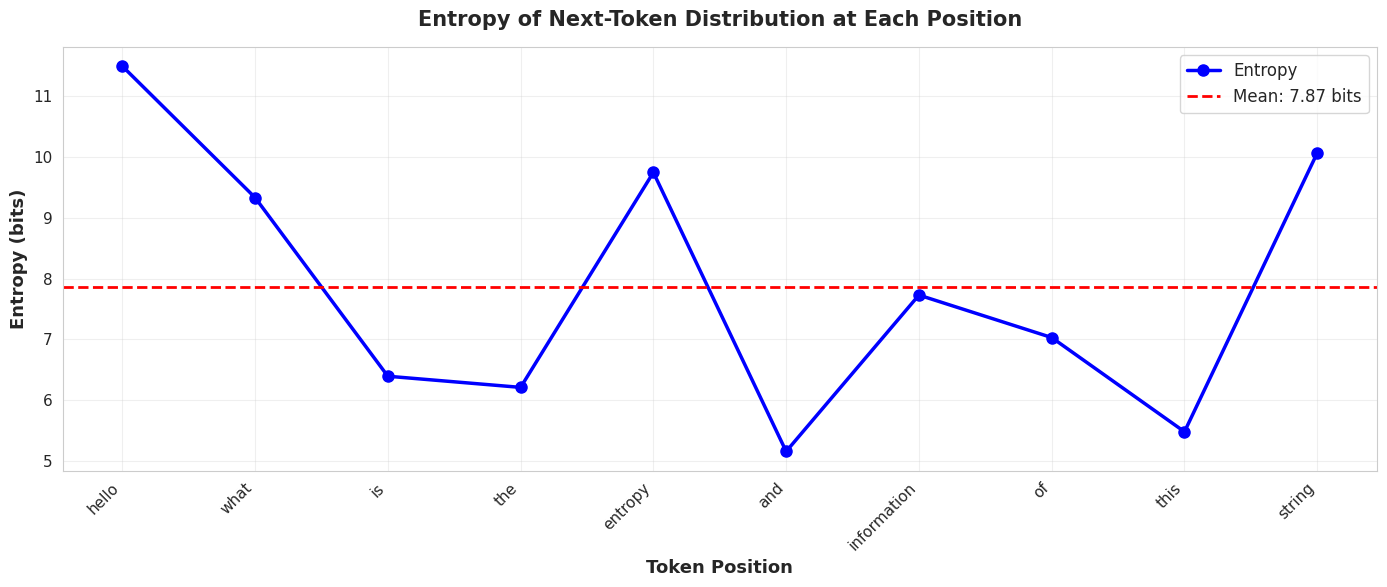


✓ Plot saved as 'entropy_by_position.png'


In [8]:
# Plot 1: Entropy across positions
fig, ax = plt.subplots(figsize=(14, 6))

positions = df['Position']
entropies = df['Entropy (bits)'].astype(float)

# Line plot with markers
ax.plot(positions, entropies, 'b-o', linewidth=2.5, markersize=8, label='Entropy')

# Add mean line
mean_entropy = entropies.mean()
ax.axhline(y=mean_entropy, color='r', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_entropy:.2f} bits')

# Styling
ax.set_xlabel('Token Position', fontsize=13, fontweight='bold')
ax.set_ylabel('Entropy (bits)', fontsize=13, fontweight='bold')
ax.set_title('Entropy of Next-Token Distribution at Each Position', 
             fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Set x-axis ticks to show tokens
ax.set_xticks(positions)
ax.set_xticklabels(df['Token'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('entropy_by_position.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved as 'entropy_by_position.png'")

## 7. Visualization: Information (Surprisal) vs Position

This shows how surprising each token was to the model:

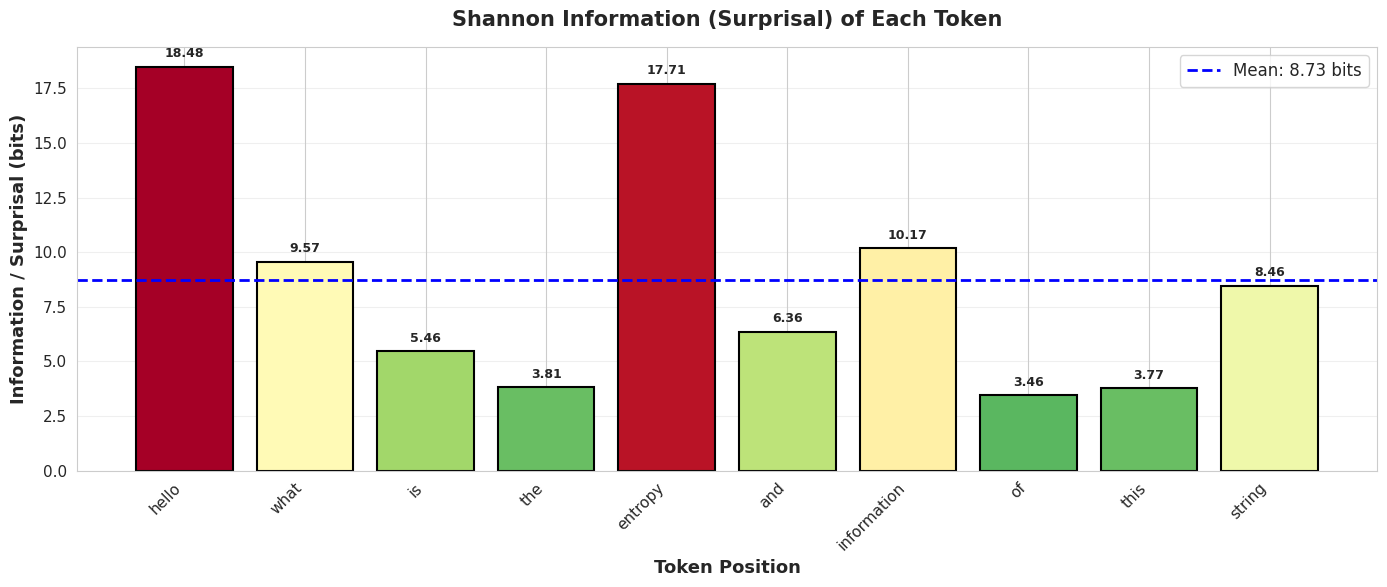


✓ Plot saved as 'information_by_position.png'


In [9]:
# Plot 2: Information (surprisal) across positions
fig, ax = plt.subplots(figsize=(14, 6))

information = df['Information (bits)'].astype(float)

# Bar plot with colors based on value
colors = plt.cm.RdYlGn_r(information / information.max())
bars = ax.bar(positions, information, color=colors, edgecolor='black', linewidth=1.5)

# Add mean line
mean_info = information.mean()
ax.axhline(y=mean_info, color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_info:.2f} bits')

# Styling
ax.set_xlabel('Token Position', fontsize=13, fontweight='bold')
ax.set_ylabel('Information / Surprisal (bits)', fontsize=13, fontweight='bold')
ax.set_title('Shannon Information (Surprisal) of Each Token', 
             fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=12)

# Set x-axis ticks
ax.set_xticks(positions)
ax.set_xticklabels(df['Token'], rotation=45, ha='right')

# Add value labels on bars
for i, (pos, val) in enumerate(zip(positions, information)):
    ax.text(pos, val + 0.3, f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('information_by_position.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved as 'information_by_position.png'")

## 8. Combined Visualization: Entropy and Information

Comparing uncertainty (entropy) vs surprise (information) on the same plot:

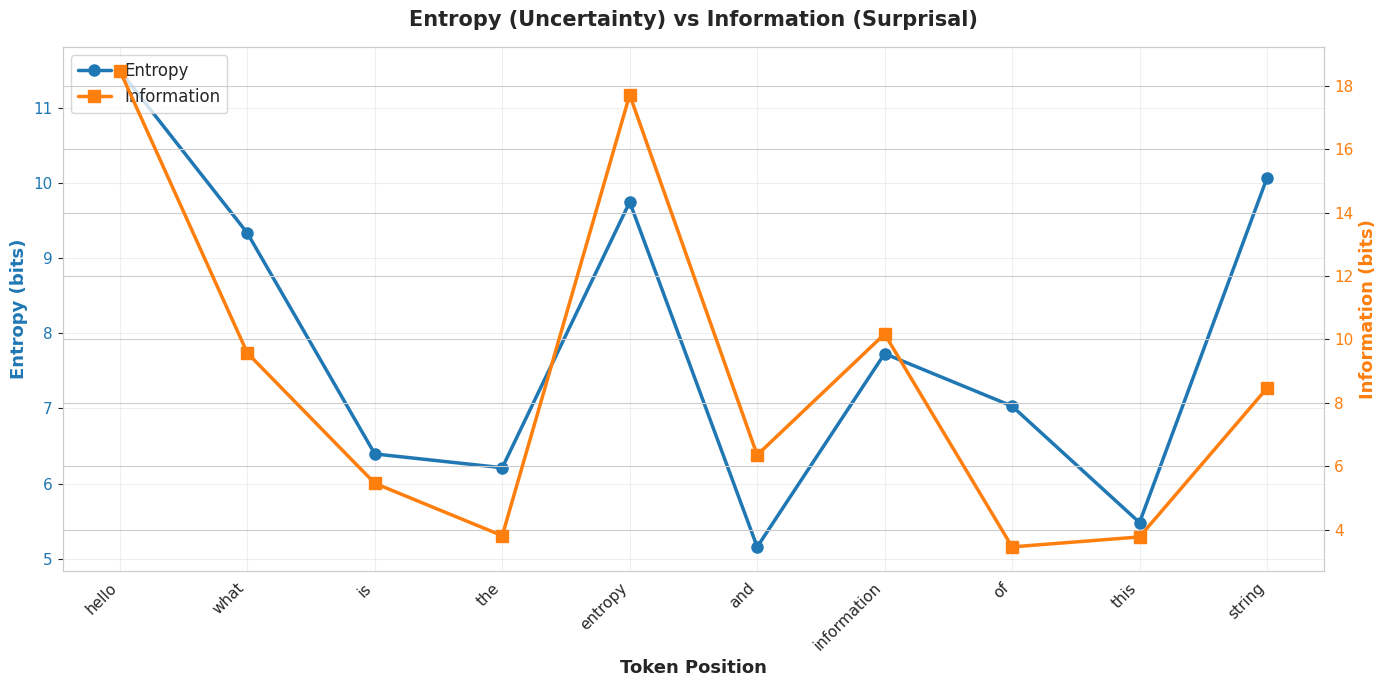


✓ Plot saved as 'entropy_vs_information.png'


In [10]:
# Plot 3: Combined plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot entropy on left axis
color1 = 'tab:blue'
ax1.set_xlabel('Token Position', fontsize=13, fontweight='bold')
ax1.set_ylabel('Entropy (bits)', color=color1, fontsize=13, fontweight='bold')
line1 = ax1.plot(positions, entropies, 'o-', color=color1, linewidth=2.5, 
                 markersize=8, label='Entropy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for information
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Information (bits)', color=color2, fontsize=13, fontweight='bold')
line2 = ax2.plot(positions, information, 's-', color=color2, linewidth=2.5, 
                 markersize=8, label='Information')
ax2.tick_params(axis='y', labelcolor=color2)

# Set x-axis
ax1.set_xticks(positions)
ax1.set_xticklabels(df['Token'], rotation=45, ha='right')

# Title and legend
ax1.set_title('Entropy (Uncertainty) vs Information (Surprisal)', 
              fontsize=15, fontweight='bold', pad=15)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('entropy_vs_information.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved as 'entropy_vs_information.png'")

## 9. Analysis: Key Findings

Let's identify interesting patterns:

In [11]:
# Find extremes
max_entropy_idx = df['Entropy (bits)'].astype(float).idxmax()
min_entropy_idx = df['Entropy (bits)'].astype(float).idxmin()
max_info_idx = df['Information (bits)'].astype(float).idxmax()
min_info_idx = df['Information (bits)'].astype(float).idxmin()

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("\n📊 ENTROPY (Model's Uncertainty):")
print(f"\n  Highest entropy: '{df.loc[max_entropy_idx, 'Token']}' at position {max_entropy_idx + 1}")
print(f"    → Entropy: {df.loc[max_entropy_idx, 'Entropy (bits)']} bits")
print(f"    → Model was VERY UNCERTAIN about what comes next")
print(f"\n  Lowest entropy: '{df.loc[min_entropy_idx, 'Token']}' at position {min_entropy_idx + 1}")
print(f"    → Entropy: {df.loc[min_entropy_idx, 'Entropy (bits)']} bits")
print(f"    → Model was CONFIDENT about what comes next")

print("\n💡 INFORMATION (Token Surprisal):")
print(f"\n  Most surprising token: '{df.loc[max_info_idx, 'Token']}' at position {max_info_idx + 1}")
print(f"    → Information: {df.loc[max_info_idx, 'Information (bits)']} bits")
print(f"    → Probability: {df.loc[max_info_idx, 'Probability']}")
print(f"    → This token was VERY UNLIKELY given the context")
print(f"\n  Most expected token: '{df.loc[min_info_idx, 'Token']}' at position {min_info_idx + 1}")
print(f"    → Information: {df.loc[min_info_idx, 'Information (bits)']} bits")
print(f"    → Probability: {df.loc[min_info_idx, 'Probability']}")
print(f"    → This token was HIGHLY PREDICTABLE")

print("\n📈 OVERALL SEQUENCE:")
print(f"\n  Total entropy: {results['total_entropy_sum']:.2f} bits")
print(f"    → This is the entropy of the entire sequence (sum of conditional entropies)")
print(f"\n  Total information: {results['total_information']:.2f} bits")
print(f"    → This sequence contains {results['total_information']:.2f} bits of surprise")
print(f"    → Sequence probability: 2^(-{results['total_information']:.2f}) ≈ {2**(-results['total_information']):.2e}")
print(f"\n  Perplexity: {results['perplexity']:.2f}")
print(f"    → On average, model was as uncertain as choosing from ~{results['perplexity']:.0f} tokens")

# Compare entropy vs information
entropy_avg = results['total_entropy_avg']
info_avg = results['avg_information']
diff = info_avg - entropy_avg

print(f"\n🔍 COMPARISON:")
print(f"\n  Average entropy: {entropy_avg:.4f} bits (expected uncertainty)")
print(f"  Average information: {info_avg:.4f} bits (observed surprise)")
print(f"  Difference: {diff:.4f} bits")

if diff > 0.5:
    print(f"\n  → This sequence was MORE surprising than average!")
    print(f"    The model didn't expect these tokens.")
elif diff < -0.5:
    print(f"\n  → This sequence was LESS surprising than average!")
    print(f"    The model found these tokens predictable.")
else:
    print(f"\n  → This sequence had typical surprise levels.")

print("\n" + "=" * 80)


KEY FINDINGS

📊 ENTROPY (Model's Uncertainty):

  Highest entropy: 'hello' at position 1
    → Entropy: 11.5 bits
    → Model was VERY UNCERTAIN about what comes next

  Lowest entropy: 'and' at position 6
    → Entropy: 5.15625 bits
    → Model was CONFIDENT about what comes next

💡 INFORMATION (Token Surprisal):

  Most surprising token: 'hello' at position 1
    → Information: 18.476438043942988 bits
    → Probability: 2.7418136596679688e-06
    → This token was VERY UNLIKELY given the context

  Most expected token: 'of' at position 8
    → Information: 3.456968179744762 bits
    → Probability: 0.091064453125
    → This token was HIGHLY PREDICTABLE

📈 OVERALL SEQUENCE:

  Total entropy: 78.66 bits
    → This is the entropy of the entire sequence (sum of conditional entropies)

  Total information: 87.25 bits
    → This sequence contains 87.25 bits of surprise
    → Sequence probability: 2^(-87.25) ≈ 5.43e-27

  Perplexity: 423.17
    → On average, model was as uncertain as choosin

## 10. Interactive: Try Your Own String!

In [12]:
# Try analyzing your own string!
# Uncomment and modify:

# your_string = "The quick brown fox jumps over the lazy dog"
# your_results = analyzer.analyze_string(your_string, prompt="")

# # Create DataFrame
# your_df = pd.DataFrame({
#     'Token': your_results['tokens'],
#     'Entropy': your_results['entropies'],
#     'Information': your_results['information']
# })
# print(your_df)

## Summary

### What We Computed:

1. **Entropy at each position**: $H(T_i | T_{1:i-1})$ - the model's uncertainty about the next token
2. **Information for each token**: $I(t_i) = -\log_2 P(t_i)$ - how surprising each observed token was
3. **Total sequence entropy**: $\sum_i H_i$ - total uncertainty in the sequence
4. **Total information**: $\sum_i I_i = -\log_2 P(\text{sequence})$ - total surprise in the sequence

### Key Takeaways:

- **Entropy varies** based on context (unlike mock distributions)
- **Technical/rare words** have high information (surprising)
- **Common/predictable words** have low information (expected)
- **Total entropy** is the true joint entropy via chain rule
- **Perplexity** represents effective vocabulary size

### Next Steps:

1. Try different strings and compare results
2. Use different models (Llama, GPT, etc.)
3. Analyze how entropy changes with more context
4. Use these metrics for:
   - Model evaluation (lower perplexity = better)
   - Text quality assessment
   - Generation intervention strategies